# 1. Preparación de los datos

In [983]:
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [984]:
df = pd.read_csv('../dataset/Leads.csv')
print(len(df))
df.head().T

9240


,0,1,2,3,4
Prospect ID,7927b2df-8bba-4d29-b9a2-b6e0beafe620,2a272436-5132-4136-86fa-dcc88c88f482,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,3256f628-e534-4826-9d63-4a8b88782852
Lead Number,660737,660728,660727,660719,660681
Lead Origin,API,API,Landing Page Submission,Landing Page Submission,Landing Page Submission
Lead Source,Olark Chat,Organic Search,Direct Traffic,Direct Traffic,Google
Do Not Email,No,No,No,No,No
Do Not Call,No,No,No,No,No
Converted,0,0,1,0,1
TotalVisits,0.0,5.0,2.0,1.0,2.0
Total Time Spent on Website,0,674,1532,305,1428
Page Views Per Visit,0.0,2.5,2.0,1.0,1.0


In [985]:
#Convert all data to lower case if it is a string
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

#Convert column names to lower case and replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_').str.lower()

#Replace all 'Select' with NaN
df.replace('Select', np.nan, inplace=True)

In [986]:
#Drop row if it has more than 60% missing values
print("Total rows before dropping:", len(df))
print("Total of rows with missing values:", df.isnull().sum().sum())
df.dropna(axis = 0, subset = df.columns[df.isnull().sum() > len(df) * 0.5], inplace = True)
print("Total rows after dropping:", len(df))
print("Total of rows with missing values after dropping:", df.isnull().sum().sum())
print("------------------------------------------------------")

#Print the number of missing values for the most important features
print(df.isnull().sum().sort_values(ascending=False).head(10))

Total rows before dropping: 9240
Total of rows with missing values: 41039
Total rows after dropping: 4473
Total of rows with missing values after dropping: 9398
------------------------------------------------------
asymmetrique_profile_score     2024
asymmetrique_activity_score    2024
asymmetrique_profile_index     2024
asymmetrique_activity_index    2024
country                         977
totalvisits                      99
page_views_per_visit             99
last_activity                    78
tags                             27
lead_source                      22
dtype: int64


In [987]:
df['asymmetrique_profile_score'] = df['asymmetrique_profile_score'].fillna(0)
df['asymmetrique_activity_score'] = df['asymmetrique_activity_score'].fillna(0)
df['asymmetrique_profile_index'] = df['asymmetrique_profile_index'].fillna("notselected")
df['asymmetrique_activity_index'] = df['asymmetrique_activity_index'].fillna("notselected")
df['country'] = df['country'].fillna("notselected")
df['totalvisits'] = df['totalvisits'].fillna(0)
df['page_views_per_visit'] = df['page_views_per_visit'].fillna(0)
df['last_activity'] = df['last_activity'].fillna("notselected")
df['tags'] = df['tags'].fillna("notselected")
df['lead_source'] = df['lead_source'].fillna("notselected")

#Print the number of missing values for each column
print("Number of missing values:", df.isnull().sum().sum())


Number of missing values: 0


In [988]:
#Get column types that are numeric
df_numeric = df.select_dtypes(include=['int64', 'float64'])
df_numeric.head().T

,0,2,3,4,6
lead_number,660737.0,660727.0,660719.0,660681.0,660673.0
converted,0.0,1.0,0.0,1.0,1.0
totalvisits,0.0,2.0,1.0,2.0,2.0
total_time_spent_on_website,0.0,1532.0,305.0,1428.0,1640.0
page_views_per_visit,0.0,2.0,1.0,1.0,2.0
asymmetrique_activity_score,15.0,14.0,13.0,15.0,14.0
asymmetrique_profile_score,15.0,20.0,17.0,18.0,20.0


In [989]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=1)

y_train = df_train.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_test['converted']

# 2. Análisis de importancia de propiedades

In [990]:
print("Mean of target value:", round(df.converted.mean(),3))

Mean of target value: 0.567


C:\Users\Antonio-PC\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

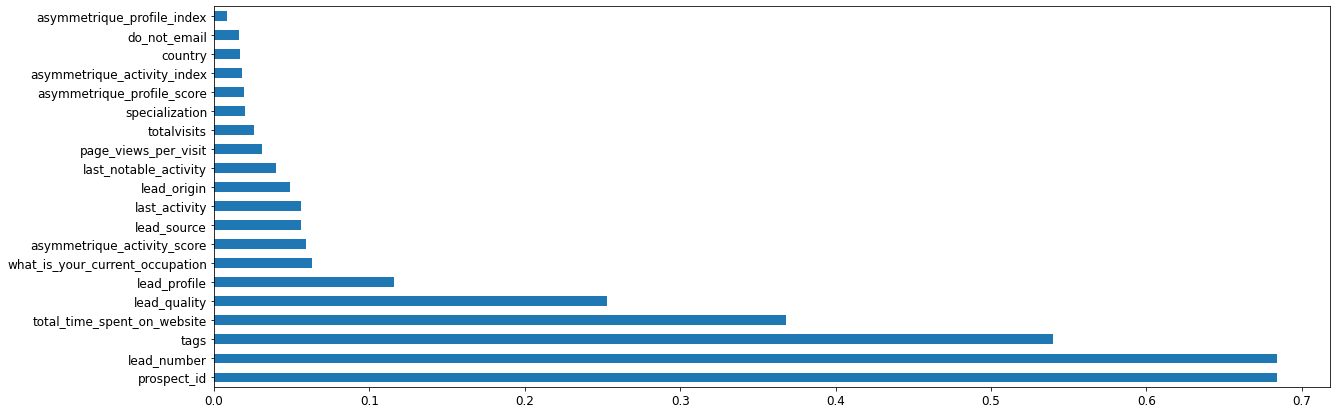

In [991]:
df_mi = df_train.apply(lambda col: mutual_info_score(col, y_train)).sort_values(ascending=False).head(20)
round(df_mi,3).plot(kind='barh', figsize=(20,7), fontsize=12)

In [992]:
#Remove columns that are not important [prospect_id, lead_number]
df_mi = df_mi.drop(['prospect_id', 'lead_number', "total_time_spent_on_website"])

# 3. Ingeniería de propiedades

In [993]:
train_dict = df_train[df_mi.index].to_dict(orient='records')
print(train_dict[0])
dv = DictVectorizer(sparse=False).fit(train_dict)

{'tags': 'already a student', 'lead_quality': 'worst', 'lead_profile': 'student of someschool', 'what_is_your_current_occupation': 'student', 'asymmetrique_activity_score': 0.0, 'lead_source': 'olark chat', 'last_activity': 'olark chat conversation', 'lead_origin': 'api', 'last_notable_activity': 'modified', 'page_views_per_visit': 0.0, 'totalvisits': 0.0, 'specialization': 'select', 'asymmetrique_profile_score': 0.0, 'asymmetrique_activity_index': 'notselected', 'country': 'notselected', 'do_not_email': 'no', 'asymmetrique_profile_index': 'notselected'}


In [994]:
X_train = dv.transform(train_dict)
X_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

# 4. Entrenamiento del modelo

In [995]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', max_iter=60).fit(X_train, y_train)
print("Accuracy of training set:", round(LR.score(X_train, y_train),3))

Accuracy of training set: 0.96


C:\Users\Antonio-PC\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [996]:
val_dict = df_test[df_mi.index].to_dict(orient='records')
X_val = dv.transform(val_dict)

print("Accuracy of validation set:", round(metrics.accuracy_score(y_test, LR.predict(X_val)),3))

Accuracy of validation set: 0.961


# 5. Serialización del modelo

In [997]:
import pickle

In [998]:
with open('../model/churn-model.pkl', 'wb') as f:
    pickle.dump((dv, LR), f)

In [999]:
with open('../model/churn-model.pkl', 'rb') as f:
    dv, model = pickle.load(f)
    X_val = dv.transform(val_dict)
    y_pred = model.predict_proba(X_val)

y_pred

array([[0.05819896, 0.94180104],
       [0.9859346 , 0.0140654 ],
       [0.0196625 , 0.9803375 ],
       ...,
       [0.01490909, 0.98509091],
       [0.22330071, 0.77669929],
       [0.92288477, 0.07711523]])